Rate on 2024-09-11: 6.4e-05
Rate on 2024-09-12: 6.4e-05
Rate on 2024-09-13: 6.4e-05
Rate on 2024-09-14: 6.4e-05
Rate on 2024-09-15: 6.4e-05
Rate on 2024-09-16: 6.4e-05
Rate on 2024-09-17: 6.4e-05
Rate on 2024-09-18: 6.4e-05
Rate on 2024-09-19: 6.4e-05
Rate on 2024-09-20: 6.4e-05
Rate on 2024-09-21: 6.4e-05
Rate on 2024-09-22: 6.4e-05
Rate on 2024-09-23: 6.4e-05
Rate on 2024-09-24: 6.4e-05
Rate on 2024-09-25: 6.4e-05
Rate on 2024-09-26: 6.4e-05
Rate on 2024-09-27: 6.4e-05
Rate on 2024-09-28: 6.4e-05
Rate on 2024-09-29: 6.4e-05
Rate on 2024-09-30: 6.4e-05
Rate on 2024-10-01: 6.4e-05
Rate on 2024-10-02: 6.4e-05
Rate on 2024-10-03: 6.4e-05
Rate on 2024-10-04: 6.4e-05
Rate on 2024-10-05: 6.4e-05
Rate on 2024-10-06: 6.4e-05
Rate on 2024-10-07: 6.4e-05
Rate on 2024-10-08: 6.4e-05
Rate on 2024-10-09: 6.4e-05
Rate on 2024-10-10: 6.4e-05
Rate on 2024-10-11: 6.4e-05
Mean Squared Error: 0.00


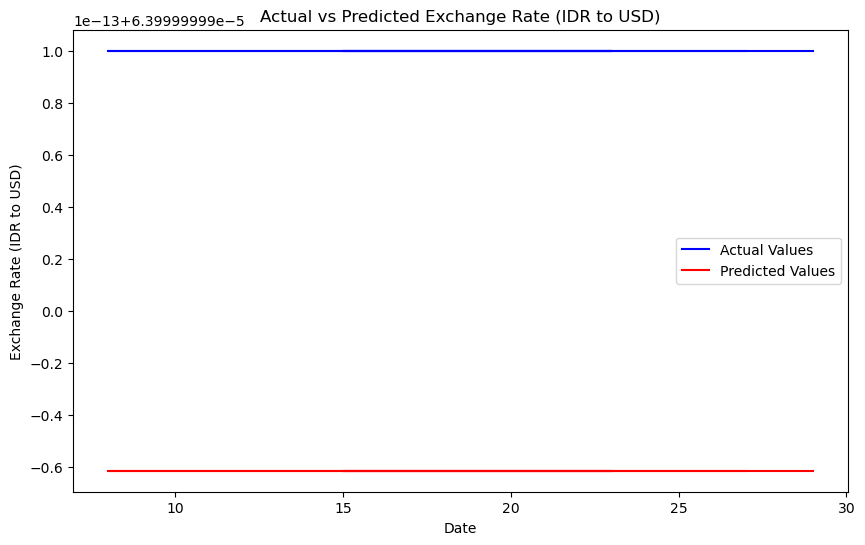

                            Forecast_Rate
2024-10-12 10:14:40.063469       0.000064
2024-10-13 10:14:40.063469       0.000064
2024-10-14 10:14:40.063469       0.000064
2024-10-15 10:14:40.063469       0.000064
2024-10-16 10:14:40.063469       0.000064
2024-10-17 10:14:40.063469       0.000064
2024-10-18 10:14:40.063469       0.000064


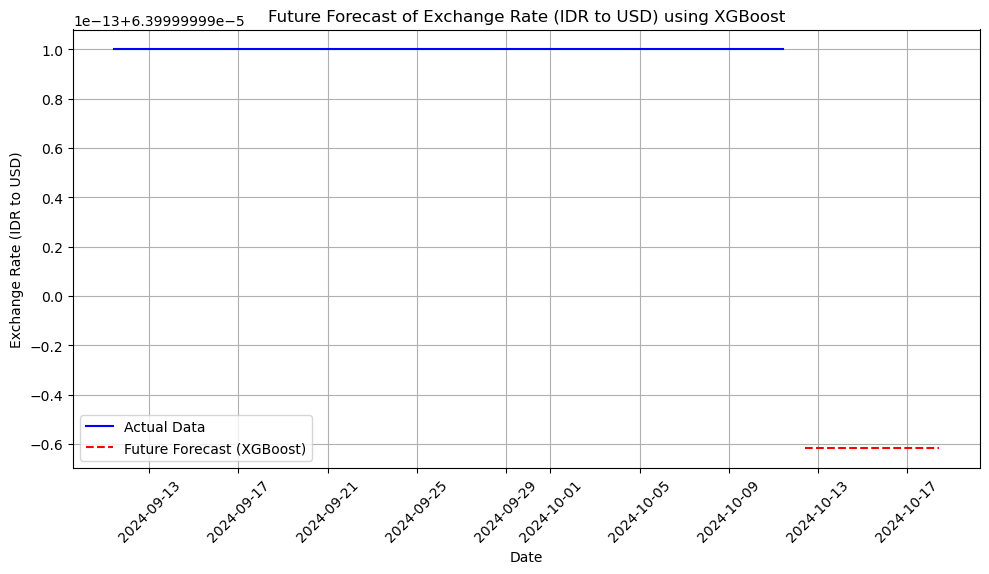

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from datetime import datetime, timedelta

# Fungsi untuk mengambil data kurs dari API
def get_exchange_rate_data(api_key, base_currency, target_currency):
    url = f"https://open.er-api.com/v6/latest/{base_currency}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data['rates'][target_currency]
    else:
        raise Exception(f"Error fetching data: {response.status_code}")

# Menggunakan API key dan mata uang
API_KEY = 'YOUR_API_KEY'  # Ganti dengan API Key kamu jika diperlukan
BASE_CURRENCY = 'IDR'  # Rupiah
TARGET_CURRENCY = 'USD'  # Dollar

# Ambil data kurs historis
def get_historical_rates(base_currency, target_currency, days=30):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    dates = pd.date_range(start=start_date, end=end_date)
    rates = []

    for date in dates:
        rate = get_exchange_rate_data(API_KEY, base_currency, target_currency)
        rates.append(rate)
        print(f"Rate on {date.strftime('%Y-%m-%d')}: {rate}")

    return pd.DataFrame({'Date': dates, 'Rate': rates})

# Ambil data historis kurs
data = get_historical_rates(BASE_CURRENCY, TARGET_CURRENCY)

# Siapkan data untuk model
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

# Memilih fitur dan target
X = data[['Day', 'Month', 'Year']]
y = data['Rate']

# Membagi dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Membuat DMatrix untuk XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameter untuk XGBoost
params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5,
    'alpha': 10
}

# Melatih model
model = xgb.train(params, dtrain, num_boost_round=100)

# Melakukan prediksi
y_pred = model.predict(dtest)

# Evaluasi model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

# Plot nilai aktual vs prediksi
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Values', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Exchange Rate (IDR to USD)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (IDR to USD)')
plt.legend()
plt.show()

# Peramalan masa depan (contoh untuk 7 hari ke depan)
future_dates = pd.date_range(start=data['Date'].iloc[-1] + timedelta(days=1), periods=7, freq='D')
future_days = future_dates.day
future_months = future_dates.month
future_years = future_dates.year

# Membuat DataFrame untuk prediksi masa depan
future_df = pd.DataFrame({
    'Day': future_days,
    'Month': future_months,
    'Year': future_years
})

# Melakukan prediksi masa depan
future_dmatrix = xgb.DMatrix(future_df)

# Melakukan prediksi
future_predictions = model.predict(future_dmatrix)

# Menampilkan prediksi masa depan
forecast_df = pd.DataFrame({'Forecast_Rate': future_predictions}, index=future_dates)

# Menampilkan hasil prediksi masa depan
print(forecast_df)

# Plot peramalan masa depan
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Rate'], label='Actual Data', color='blue')
plt.plot(forecast_df, label='Future Forecast (XGBoost)', color='red', linestyle='--')
plt.title('Future Forecast of Exchange Rate (IDR to USD) using XGBoost')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (IDR to USD)')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()
